# Proyecto Numero II
## Ingeniería de features, Modelos avanzados e Interpretación de modelos


In [1]:
# Importacion de librerias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

### <strong>Parte A</strong> Transformacion de datos ###

**A.1 Importo el dataset y lo filtro al igual que en punto 5 del primer proyecto**

In [2]:
data=pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

In [3]:
data.shape

(146660, 19)

In [4]:
data=data[data.property_type.isin(['Departamento','PH','Casa']) & (data.l2=='Capital Federal')]

In [5]:
data=data[(data.surface_total<1000)&(data.surface_total>15)]
data.shape

(82392, 19)

In [6]:
data=data[data.property_type=='Departamento']
ds=data[['rooms', 'bedrooms','bathrooms','surface_total','surface_covered','price']].copy()

ds.shape

(70453, 6)

Hago una copia de mi dataset para poder trabajarlo y me quedo con los atributos que son utiles para el modelo.

**A.2 Inicio el analisis exploratorio de datos**

Evaluo Valores faltantes 

In [7]:
ds.isna().sum()

rooms                0
bedrooms             0
bathrooms          722
surface_total        0
surface_covered    433
price                0
dtype: int64

Tengo valores faltantes en "bathrooms" y "surface_covered" vamos a analizar si existe alguna relacion en los valores faltantes. para eso primero que nada amnalizaremos la correlacion con las otras variables

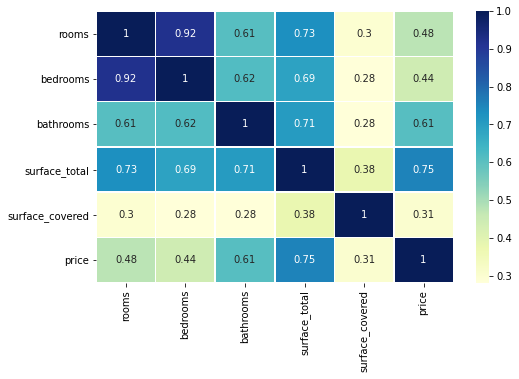

In [8]:
f, ax = plt.subplots(figsize=(8, 5))
corr = ds.corr()
sns.heatmap(corr,annot=True,linewidths=.5,cmap="YlGnBu")

Las mejores correlaciones del precio se dan con los atributos <strong> surface_total</strong>,  y <strong>bathrooms</strong> y en el caso de bathrooms es uno de los atributos que tienen mas NaN. En el trabajo número 1 eliminamos los NaN, pero para mejorar le prediccion sería bueno poder imputarlos. A continuacion analizaremos si hay alguna relacion entre <strong>rooms</strong> y <strong>bathrooms</strong> que nos permita inferir algún tipo de dependencia para luego pensar como imputarlos.

**Agrupo las habitaciones nulas por cada valor de rooms**

In [9]:
ds.bathrooms.isnull().groupby([ds['rooms']]).sum().astype(int).reset_index(name='count')


,rooms,count
0,1.0,114
1,2.0,283
2,3.0,208
3,4.0,65
4,5.0,50
5,6.0,1
6,7.0,0
7,8.0,1
8,9.0,0
9,10.0,0


Ya de esta primer agrupacion podríamos empezar a inferir que la mayoría de los valores nules se encuentran en las propiedades que tienen menos habitaciones

Vamos a aplicar una técnica de "binning" para agrupar los datops en 15 rangos de manera de poder analizar mejor cómo distribullen

In [10]:
ds_copy=ds.copy()
ds_copy['rooms-intervalos'] = pd.cut(ds_copy.rooms, bins  = 15)
ds_copy

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,rooms-intervalos
0,7.0,7.0,2.0,140.0,140.0,153000.0,"(6.333, 7.667]"
11,2.0,1.0,1.0,68.0,59.0,149000.0,"(0.98, 2.333]"
12,2.0,1.0,1.0,50.0,44.0,115000.0,"(0.98, 2.333]"
20,2.0,1.0,1.0,31.0,31.0,75000.0,"(0.98, 2.333]"
21,1.0,1.0,1.0,22.0,22.0,48000.0,"(0.98, 2.333]"
...,...,...,...,...,...,...,...
146551,4.0,3.0,2.0,103.0,98.0,660000.0,"(3.667, 5.0]"
146552,4.0,2.0,3.0,159.0,98.0,539000.0,"(3.667, 5.0]"
146553,4.0,3.0,2.0,106.0,100.0,620000.0,"(3.667, 5.0]"
146557,3.0,2.0,2.0,145.0,145.0,420000.0,"(2.333, 3.667]"


In [11]:
#binneo
ds_rooms_bathrooms = ds_copy.bathrooms.isnull().groupby([ds_copy['rooms-intervalos']]).sum().astype(int).reset_index(name='count')
ds_rooms_bathrooms

,rooms-intervalos,count
0,"(0.98, 2.333]",397
1,"(2.333, 3.667]",208
2,"(3.667, 5.0]",115
3,"(5.0, 6.333]",1
4,"(6.333, 7.667]",0
5,"(7.667, 9.0]",1
6,"(9.0, 10.333]",0
7,"(10.333, 11.667]",0
8,"(11.667, 13.0]",0
9,"(13.0, 14.333]",0


In [12]:
# Calculo la frecuencia
ds_rooms_bathrooms['freq'] = ds_rooms_bathrooms['count']/ds_copy.groupby([ds_copy['rooms-intervalos']]).count()['rooms'].values
ds_rooms_bathrooms

,rooms-intervalos,count,freq
0,"(0.98, 2.333]",397,0.013365
1,"(2.333, 3.667]",208,0.009289
2,"(3.667, 5.0]",115,0.006911
3,"(5.0, 6.333]",1,0.000939
4,"(6.333, 7.667]",0,0.000000
5,"(7.667, 9.0]",1,0.004149
6,"(9.0, 10.333]",0,0.000000
7,"(10.333, 11.667]",0,0.000000
8,"(11.667, 13.0]",0,0.000000
9,"(13.0, 14.333]",0,0.000000


In [13]:
ds_rooms_bathrooms["bin_centres"] = ds_rooms_bathrooms['rooms-intervalos'].apply(lambda x: x.mid)
ds_rooms_bathrooms

,rooms-intervalos,count,freq,bin_centres
0,"(0.98, 2.333]",397,0.013365,1.6565
1,"(2.333, 3.667]",208,0.009289,3.0000
2,"(3.667, 5.0]",115,0.006911,4.3335
3,"(5.0, 6.333]",1,0.000939,5.6665
4,"(6.333, 7.667]",0,0.000000,7.0000
5,"(7.667, 9.0]",1,0.004149,8.3335
6,"(9.0, 10.333]",0,0.000000,9.6665
7,"(10.333, 11.667]",0,0.000000,11.0000
8,"(11.667, 13.0]",0,0.000000,12.3335
9,"(13.0, 14.333]",0,0.000000,13.6665


**Grafico la relacion**

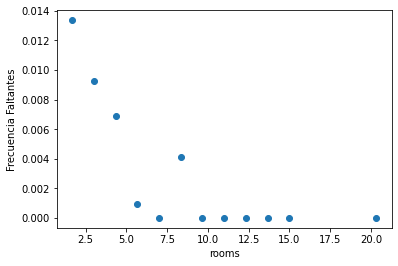

In [14]:
plt.scatter(ds_rooms_bathrooms['bin_centres'], ds_rooms_bathrooms['freq'])
plt.xlabel('rooms')
plt.ylabel('Frecuencia Faltantes')
plt.show()

Claramente  hay una relación entre los valores nulos de las habitaciones y los baños. Cuando la cantidad de habitaciones se encuentra entre 1 y 3 se dan la mayor cantidad de valores nulos. Podríamos pensar que como la cantidad de habitaciones es baja cuando se  recolectaron los datos se asumió que siempre en ese rango de habitaciones había un baño y por eso ese dato está faltante. Dado que en el modelo anterior lo eliminamos en este modelo lo imputaremos.

**A.1 Depuracion de valores faltantes**

Si bien por el análisis hecho anteriormente sabemos que debemos imputar aqui deberemos tomar una desicion:

+ Imputar y luego aplicar depuración de outliers
+ Depurar outliers primero y luego imputar

Lo que decidiremos, por lo visto durante el curso, es que vamos a depurar outliers antes de imputar pues eso si lo hiciéramos de manera inversa los outliers afectarían los estadísticos del modelo como son la media y el desvío estándar y podrían afectar el proceso de imputación. De hecho hemos comprobado en cálculos adicionales que haciéndolo de este modelo mejora su predicción un 1% dependiendo del orden en que hagamos las cosas. Por lo tanto primero aplicamos outliers


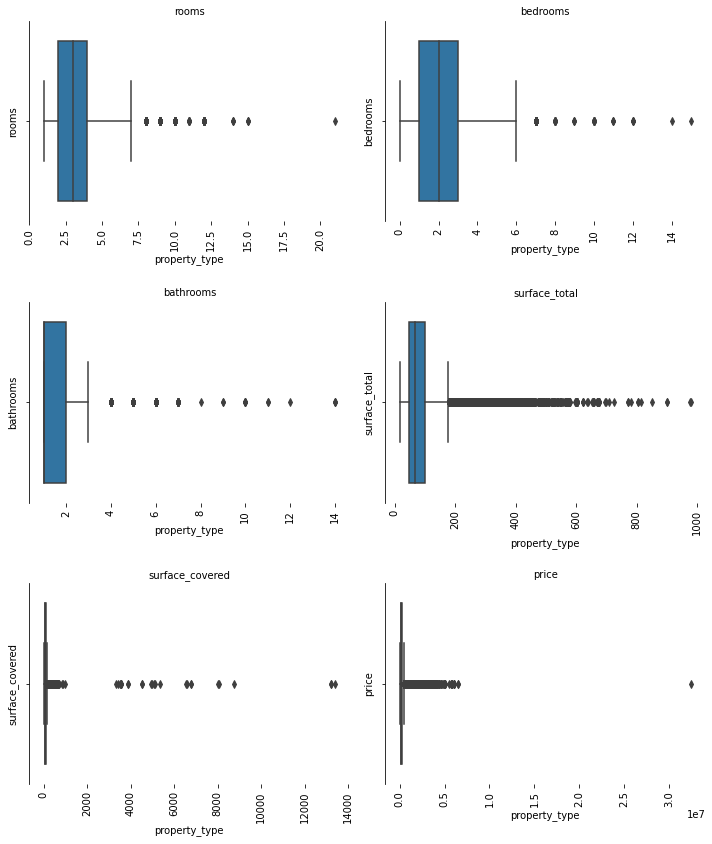

In [15]:

#Defino la figura para los dos graficos
fig = plt.figure(figsize = (10, 15))
#Agrego un gridspec para poder darle a cada grafico el tamano correpsondiente
gs = fig.add_gridspec(4, 2)

atributos=ds.columns

fila=0
columna=0
for tipo in atributos:
    if tipo!='property_type':
        ax = fig.add_subplot(gs[fila,columna])
        ax=sns.boxplot(tipo, data=ds)
        plt.setp(ax.get_xticklabels(), rotation=90)
        titulo=tipo
        ax.set_title(titulo,fontsize=10)
        ax.tick_params(labelsize=10)
        ax.set_xlabel("property_type",fontsize=10)
        ax.set_ylabel(tipo,fontsize=10)
        
        if columna<1:
            columna=columna+1
        else:
            columna=0
            fila=fila+1

#doy el formato final al grafico
sns.despine(bottom=True)
#plt.setp(fig.axes, yticks=[])
plt.tight_layout(h_pad=2)

In [16]:
# Calculo elcuartil #1 y el cuarti #3
minimo = ds.quantile(0.25)
maximo = ds.quantile(0.75)
#Calculo un Indice restando el cuartil 3 con el cuartil 1
IQR = maximo-minimo
#genero una mascara que traiga todos las instancias del dataset que esten por debajo del quartil 1 menos el coeficiente IQR  y por sobre el cuartil 3 mas el coeficiente IQR
ds = ds[~ ((ds< (minimo - 1.5 * IQR)) | (ds > (maximo + 1.5 * IQR))).any(axis=1)]

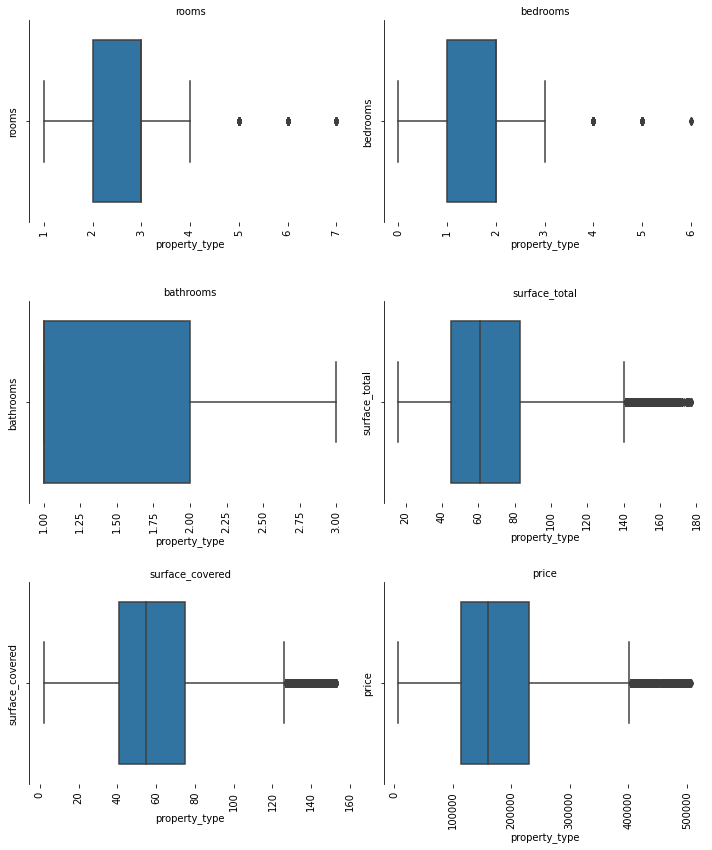

In [17]:

#Defino la figura para los dos graficos
fig = plt.figure(figsize = (10, 15))
#Agrego un gridspec para poder darle a cada grafico el tamano correpsondiente
gs = fig.add_gridspec(4, 2)

atributos=ds.columns

fila=0
columna=0
for tipo in atributos:
    if tipo!='property_type':
        ax = fig.add_subplot(gs[fila,columna])
        ax=sns.boxplot(tipo, data=ds)
        plt.setp(ax.get_xticklabels(), rotation=90)
        titulo=tipo
        ax.set_title(titulo,fontsize=10)
        ax.tick_params(labelsize=10)
        ax.set_xlabel("property_type",fontsize=10)
        ax.set_ylabel(tipo,fontsize=10)
        
        if columna<1:
            columna=columna+1
        else:
            columna=0
            fila=fila+1

#doy el formato final al grafico
sns.despine(bottom=True)
#plt.setp(fig.axes, yticks=[])
plt.tight_layout(h_pad=2)

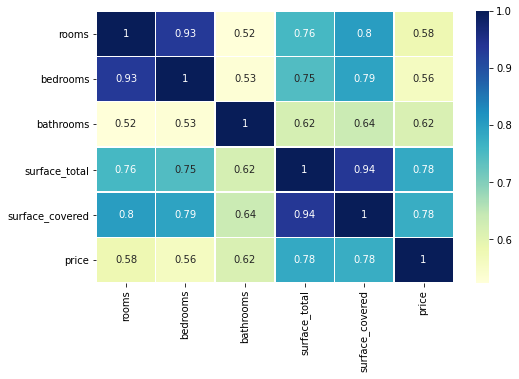

In [18]:
f, ax = plt.subplots(figsize=(8, 5))
corr = ds.corr()
sns.heatmap(corr,annot=True,linewidths=.5,cmap="YlGnBu")

In [19]:
ds.isna().sum()

rooms                0
bedrooms             0
bathrooms          672
surface_total        0
surface_covered    402
price                0
dtype: int64

Luego de la depuración de outliers nuestro modelo correlaciona mucho mejor y la cantidad de valores falantes ha disminuido pero continua manteniéndose la relación original. Ahora vamos a imputar los valores faltantes

**A.2 Imputación de valores faltantes** 

Podríamos pensar en imputarlo a través de la media pero no es recomendable porque al imputar por la media afectaríamos el desvío estándar que luego utilizaremos para eliminar outliers. Vamos a imputar mediante un modelo de vecinos más cercanos de KNNIMPUTER.

In [20]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, copy=False)
imputer.fit_transform(ds)
imputer.transform(ds)


array([[2.00000e+00, 1.00000e+00, 1.00000e+00, 6.80000e+01, 5.90000e+01,
        1.49000e+05],
       [2.00000e+00, 1.00000e+00, 1.00000e+00, 5.00000e+01, 4.40000e+01,
        1.15000e+05],
       [2.00000e+00, 1.00000e+00, 1.00000e+00, 3.10000e+01, 3.10000e+01,
        7.50000e+04],
       ...,
       [3.00000e+00, 2.00000e+00, 2.00000e+00, 8.90000e+01, 8.20000e+01,
        4.34999e+05],
       [3.00000e+00, 2.00000e+00, 2.00000e+00, 8.20000e+01, 8.20000e+01,
        4.75000e+05],
       [3.00000e+00, 2.00000e+00, 2.00000e+00, 1.45000e+02, 1.45000e+02,
        4.20000e+05]])

In [21]:
ds.isna().sum()

rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
dtype: int64

**A.3 Reducción de la dimensionalidad**

Como último paso del proceso de transformación de datos aplico el método de reducción de la dimensionalidad PCA

Definos los X e Y que utilizare para la evaluación del modelo

In [22]:
y=ds['price'].values
x1=ds[['surface_total']].values.T
x2=ds[['surface_covered']].values.T
x3=ds[['bathrooms']].values.T
X=np.vstack((x1,x2,x3)).T

Corro el modelo del mismo modo que en el trabajo #1 pero sin aplicar todavía PCA para evaluar el comportamiento del modelo antes y después de PCA

--------------------------
Modelo:Tree Regressor
RMSE Train: 45911.38552356568
RMSE Test: 50337.20085224176
Diferencia RMSE: 4425.815328676079
--------------------------


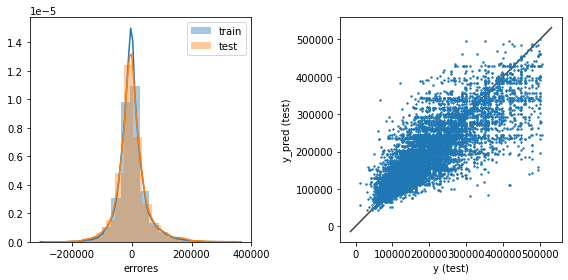

In [23]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
tree_regressor = DecisionTreeRegressor(max_depth=12, random_state=100)
tree_regressor.fit(X_train, y_train)

y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

if rmse_train> rmse_test:
      relacion=(rmse_test/rmse_train)*100
else:
    relacion=(rmse_train/rmse_test) *100 

dif=abs(rmse_train-rmse_test)
print('--------------------------')
print(f'Modelo:Tree Regressor')
print(f'RMSE Train: {rmse_train}')
print(f'RMSE Test: {rmse_test}')
print(f'Diferencia RMSE: {dif}')
print('--------------------------')
        
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()
        

        
    

En el trabajo #1 habíamos logrado un RMSE de 137.559 pesos evaluando el modelo antes de PCA obtuvimos un error de  52.567 pesos es decir una mejoría del <strong>63.5%</strong>


Aplico PCA para reducir la dimensionalidad

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_nuevo = pca.fit_transform(X) 

Text(0, 0.5, 'X_nuevo[:,1]')

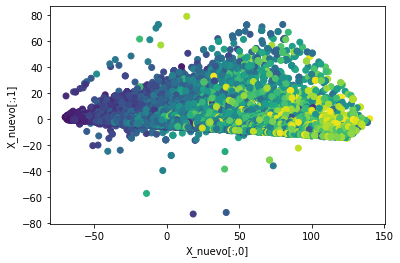

In [25]:
plt.scatter(X_nuevo[:,0], X_nuevo[:,1], c = y)
plt.xlabel('X_nuevo[:,0]')
plt.ylabel('X_nuevo[:,1]')

Entreno el modelo nuevamente

--------------------------
Modelo:Tree Regressor
RMSE Train: 45317.54687889946
RMSE Test: 50181.4017179366
Diferencia RMSE: 4863.854839037136
--------------------------


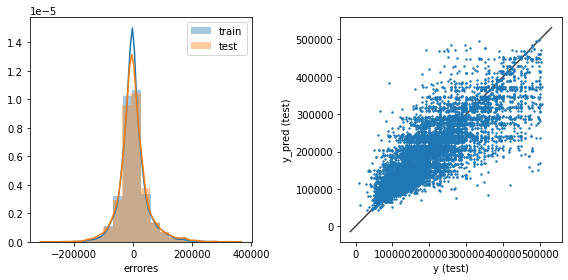

In [26]:

X_train, X_test, y_train, y_test = train_test_split(X_nuevo, y, test_size=0.20, random_state=42)
tree_regressor = DecisionTreeRegressor(max_depth=12, random_state=100)
tree_regressor.fit(X_train, y_train)

y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

if rmse_train> rmse_test:
      relacion=(rmse_test/rmse_train)*100
else:
    relacion=(rmse_train/rmse_test) *100 

dif=abs(rmse_train-rmse_test)
print('--------------------------')
print(f'Modelo:Tree Regressor')
print(f'RMSE Train: {rmse_train}')
print(f'RMSE Test: {rmse_test}')
print(f'Diferencia RMSE: {dif}')
print('--------------------------')
        
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()
        

        
    

Aplicando como ultimo metodo de transformacion de datos PCA logramos una mejoría de <strong>63%</strong> respecto del modelo original del trabajo #1. 

Si bien las tres técnicas aplicadas fueron importantes en la mejoría. Entiendo que la imputación de valores faltantes en vez de la eliminación de valores Nulos fue muy importante. Sencillamente porque no eliminamos datos del dataset y esto nos permitió un mejor aprendizaje del modelo. Se ve claramente que luego de la  imputación y la eliminación de outliers la correlación del modelo crece significativamente.

Por otro lado, el hecho de aplicar primero la depuración de outliers y luego la imputación de valores faltantes claramente mejoró el proceso de transformación de datos. Por lo que ya hemos mencionado anteriormente al aplicar la depuración de valores extremos primero y luego la imputación, los valores extremos no afectan los estadísticos para el cálculo de la imputación.




# Parte B modelos avanzados

En este apartado evaluaremos el modelo trabajado en el entregable número 1 utilizando métodos avanzados de Random Forest y regresiones lineales polinomiales. Inicialmente los evaluaremos con sus parámetros por default y luego aplicaremos técnicas de optimización de hiperparametros


**B1 Regresión polinomial**

En el trabajo #1 vimos que al aplicar un modelo de regresión lineal no era una opción por la forma que tenía la distribución de nuestros datos. En este segundo trabajo probaremos aplicando una técnica de regresión polinomial, entendiendo que incrementando el grado del polinomio podremos lograr una mejor prediccón.

**Validación cruzada**: aplicaremos técnicas de validación cruzada para poder garantizar que los resultados del modelo sean independientes de la partición entre test y train

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_nuevo, y, test_size=0.33, random_state=42)

In [29]:
clf_train_scores_mean = []
clf_train_scores_std = []
clf_test_scores_mean = []
clf_test_scores_std = []

profundidades = np.arange(1,5)

for profundidad in profundidades:
 
    # Generamos nueva matriz de features aplicando "Polinomeal Features"
    
    poly = PolynomialFeatures(degree = profundidad, include_bias=True)
    X_train_new = poly.fit_transform(X_train)
    X_test_new = poly.fit_transform(X_test)
    
    # Ejecutamos el modelo con el nuevo sets de features 
    
    reg_2 = LinearRegression()
    reg_2.fit(X_train_new, y_train)
    y_train_pred_2 = reg_2.predict(X_train_new)
    y_test_pred_2 = reg_2.predict(X_test_new)
    
    # Aplicamos validacion cruzada
    clf_scores = cross_validate(reg_2, X_test_new, y_test, cv=6, return_train_score=True, n_jobs = -1)
 
    clf_train_scores_mean.append(clf_scores['train_score'].mean())
    clf_train_scores_std.append(clf_scores['train_score'].std())
    
    clf_test_scores_mean.append(clf_scores['test_score'].mean())
    clf_test_scores_std.append(clf_scores['test_score'].std())

clf_train_scores_mean = np.array(clf_train_scores_mean)
clf_train_scores_std = np.array(clf_train_scores_std)
clf_test_scores_mean = np.array(clf_test_scores_mean)
clf_test_scores_std = np.array(clf_test_scores_std)

**Graficamos los resultados del proceso anterior para encontrar el punto óptimo**

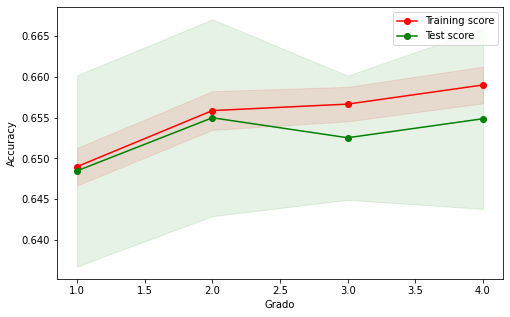

In [30]:
plt.figure(figsize=(8,5))
plt.fill_between(profundidades, clf_train_scores_mean - clf_train_scores_std,
clf_train_scores_mean + clf_train_scores_std, alpha=0.1,color="r")
plt.fill_between(profundidades, clf_test_scores_mean - clf_test_scores_std,clf_test_scores_mean + clf_test_scores_std, alpha=0.1, color="g")
plt.plot(profundidades, clf_train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(profundidades, clf_test_scores_mean, 'o-', color="g",label="Test score")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Grado')
plt.show()

Según el proceso de validación cruzada el mejor scoring en el  set de test se logra con un polinomio de grado 2. Entonces ejecutamo el modelo en base a esto.

--------------------------
Modelo:Tree Regressor
RMSE Train: 53349.54439796171
RMSE Test: 54255.96755891441
Diferencia RMSE: 906.4231609526978
--------------------------


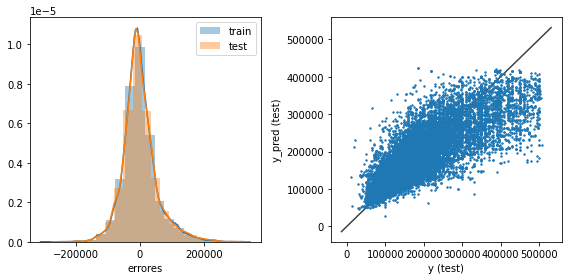

In [31]:

X_train, X_test, y_train, y_test = train_test_split(X_nuevo, y, test_size=0.33, random_state=42)

poly = PolynomialFeatures(degree =2, include_bias=True)
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)

reg_2 = LinearRegression()
reg_2.fit(X_train_new, y_train)
y_train_pred = reg_2.predict(X_train_new)
y_test_pred = reg_2.predict(X_test_new)


rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

if rmse_train> rmse_test:
      relacion=(rmse_test/rmse_train)*100
else:
    relacion=(rmse_train/rmse_test) *100 

dif=abs(rmse_train-rmse_test)
print('--------------------------')
print(f'Modelo:Tree Regressor')
print(f'RMSE Train: {rmse_train}')
print(f'RMSE Test: {rmse_test}')
print(f'Diferencia RMSE: {dif}')
print('--------------------------')
        
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()
        

        
    

Si bien el modelo de regresión lineal en el trabajo anterior se descartó. Queda claro que con un modelo de regresión polinomial la predicción mejora notablemente logrando una mejora en el  RMSE del <strong> 60% </strong> respecto de los resultados del trabajo #1

In [32]:
from sklearn.linear_model import Ridge, Lasso
reg_ridge = Ridge(alpha= 0.000002, normalize=True,solver='svd'  )
reg_ridge.fit(X_train_new,y_train)
y_train_ridge=reg_ridge.predict(X_train_new)
y_test_ridge = reg_ridge.predict(X_test_new)

In [33]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_ridge))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_ridge))
print('--------------------------') 
print(f'RMSE Train: {rmse_train}')
print(f'RMSE Test: {rmse_test}')
print('--------------------------')

--------------------------
RMSE Train: 53349.544398759026
RMSE Test: 54255.9682270097
--------------------------


# RandomForest

A continuación vamos a ejecutar la predicción mediante un modelo de Random Forest. Inicialmente lo haremos con los parámetros originales y luego aplicaremos técnicas de optimización de hiperparametros

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_nuevo, y, test_size=0.33, random_state=42)

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
X, y = make_regression(n_features=3, n_informative=2,
                       random_state=0, shuffle=False)


Nuevamente aplicamos validación cruzada para encontrar la profundidad más propicia para el modelo.

In [37]:
from sklearn.model_selection import cross_validate
clf_train_scores_mean = []
clf_train_scores_std = []
clf_test_scores_mean = []
clf_test_scores_std = []

profundidades = np.arange(1,20,1)

for profundidad in profundidades:
 
    clf = RandomForestRegressor( max_depth=profundidad, random_state=42)
    clf_scores = cross_validate(clf, X, y, cv=5, return_train_score=True, n_jobs = -1)
    
    clf_train_scores_mean.append(clf_scores['train_score'].mean())
    clf_train_scores_std.append(clf_scores['train_score'].std())
    
    clf_test_scores_mean.append(clf_scores['test_score'].mean())
    clf_test_scores_std.append(clf_scores['test_score'].std())

clf_train_scores_mean = np.array(clf_train_scores_mean)
clf_train_scores_std = np.array(clf_train_scores_std)
clf_test_scores_mean = np.array(clf_test_scores_mean)
clf_test_scores_std = np.array(clf_test_scores_std)

Graficamos el resultado

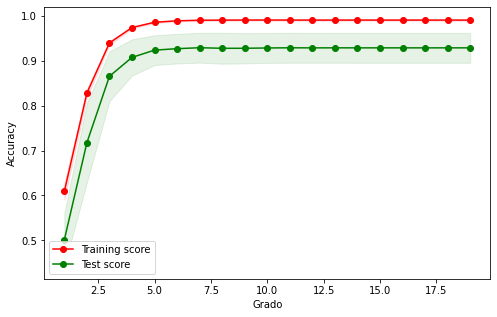

In [38]:
plt.figure(figsize=(8,5))
plt.fill_between(profundidades, clf_train_scores_mean - clf_train_scores_std,
clf_train_scores_mean + clf_train_scores_std, alpha=0.1,color="r")
plt.fill_between(profundidades, clf_test_scores_mean - clf_test_scores_std,clf_test_scores_mean + clf_test_scores_std, alpha=0.1, color="g")
plt.plot(profundidades, clf_train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(profundidades, clf_test_scores_mean, 'o-', color="g",label="Test score")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Grado')
plt.show()

In [39]:
clf = RandomForestRegressor( max_depth=6, random_state=42)
clf_scores = cross_val_score(clf, X, y, cv=7)
print("Accuracy para Tree: %0.2f (+/- %0.2f)" % (clf_scores.mean(), clf_scores.std() * 2))



Accuracy para Tree: 0.92 (+/- 0.09)


Claramente el nivel de "accuracy" del modelo es mucho mejor que al de la regresión polinomial y esto se debe a que este modelo es mas propicio para evaluar la distribución de los datos de properati.

**Evaluamos el modelo sin optimización de hiperparametros**

--------------------------
Modelo:Tree Regressor
RMSE Train: 51213.59778687849
RMSE Test: 52775.1327185141
Diferencia RMSE: 1561.5349316356078
--------------------------


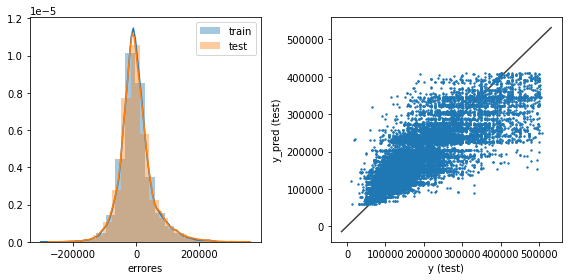

In [40]:

 
clf = RandomForestRegressor( max_depth=6, random_state=42)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)


rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

if rmse_train> rmse_test:
      relacion=(rmse_test/rmse_train)*100
else:
    relacion=(rmse_train/rmse_test) *100 

dif=abs(rmse_train-rmse_test)
print('--------------------------')
print(f'Modelo:Tree Regressor')
print(f'RMSE Train: {rmse_train}')
print(f'RMSE Test: {rmse_test}')
print(f'Diferencia RMSE: {dif}')
print('--------------------------')
        
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()
        

        
    

Aplicando randomForest logramos una mejora del <strong>61.6%</strong> levemente mejor a la regresion polinomial. Ahora aplicaremos t{ecnicas de optimizacion de hiperparametro mediante <strong>"randomsearch"</strong>

**Random Search**

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint 
rf= RandomForestRegressor()

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [42]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 110, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 5, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [43]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.1min finished


{'n_estimators': 107,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

Corremos el modelo con los hiperparametros que nos propone el randomsearch.

--------------------------
Modelo:Tree Regressor
RMSE Train: 41924.243652467594
RMSE Test: 48418.47202492294
Diferencia RMSE: 6494.228372455349
--------------------------


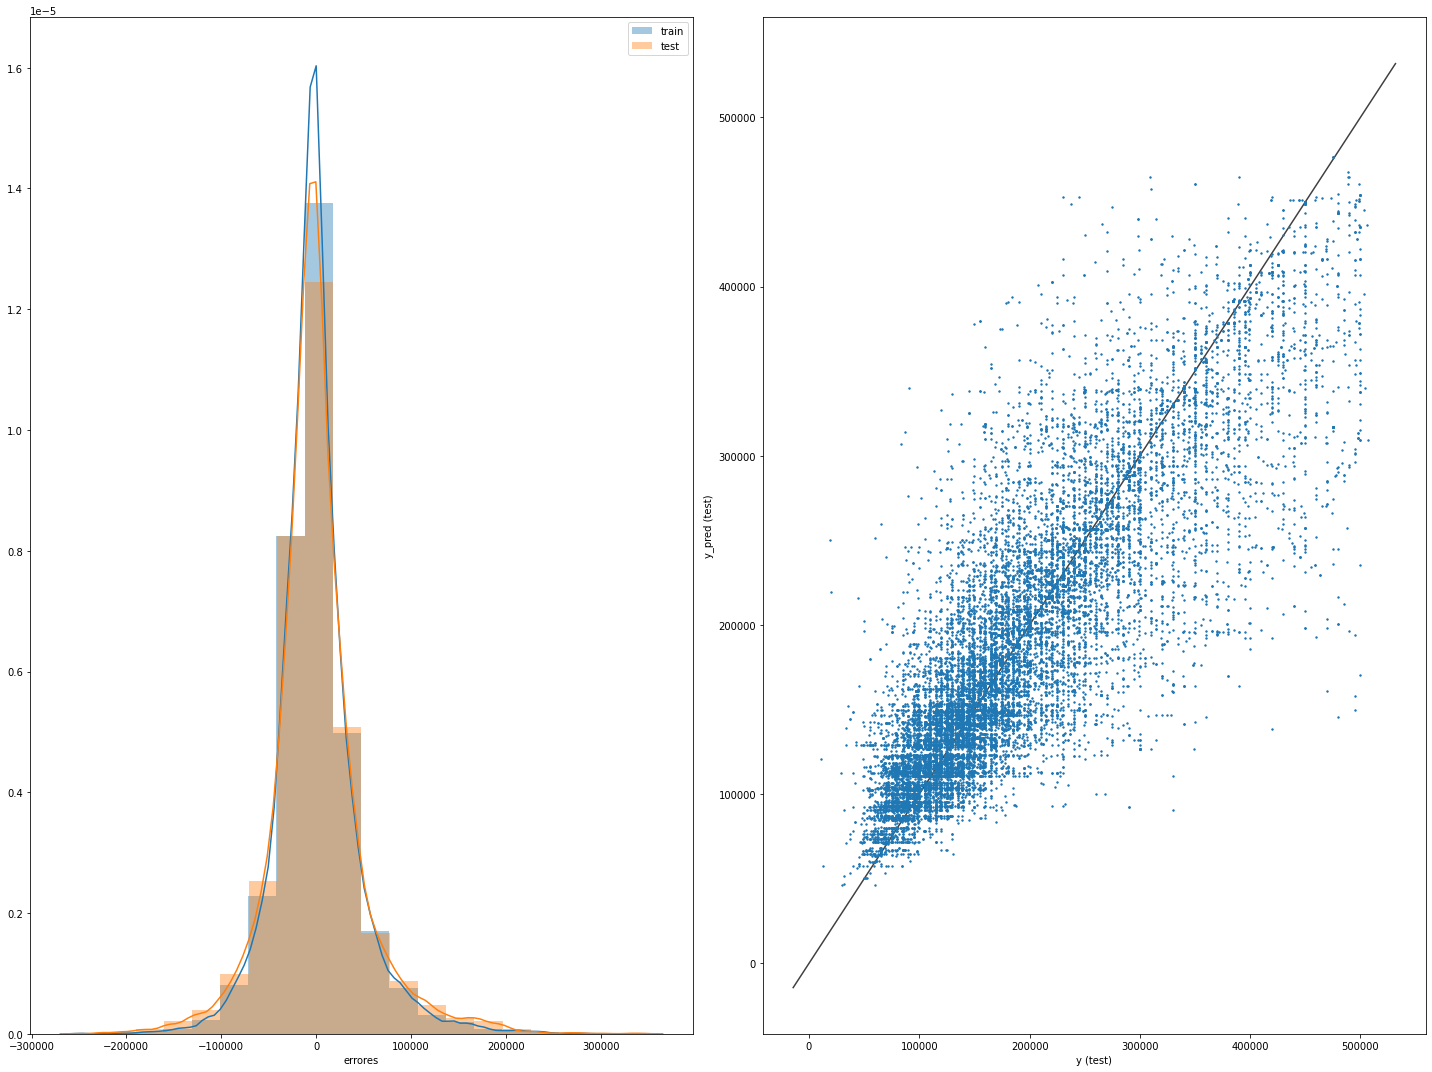

In [44]:

 
clf = RandomForestRegressor( n_estimators=107,min_samples_split=10,min_samples_leaf=1,max_features='sqrt',max_depth=None,bootstrap=True)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)


rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

if rmse_train> rmse_test:
      relacion=(rmse_test/rmse_train)*100
else:
    relacion=(rmse_train/rmse_test) *100 

dif=abs(rmse_train-rmse_test)
print('--------------------------')
print(f'Modelo:Tree Regressor')
print(f'RMSE Train: {rmse_train}')
print(f'RMSE Test: {rmse_test}')
print(f'Diferencia RMSE: {dif}')
print('--------------------------')
        
plt.figure(figsize = (20,15))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()
        

        
    

Con la optimizacion de hiperparametros logramos una mejora del <sstrong>65%</strong> respecto del modelo original del trabajo #1. Claramente la optimización de hiperparmetros mejoró la predicción. 

# Parte C Interpretacion de Modelos

**¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no?**

Las variables que fueron mas relevantes fueron:
+ surface_total
+ surface_covered
+ bathrooms

El resto de las variables no lo fueron. Y en un punto tienen cierta  logica como atributos que definen el costo de una propiedad. Sobre todo la superficie total y la superficie cubierta las cuales fueron las dos que mejores correlacionaron.Claramente las variables utilizadas coinciden con lo que veniamos viendo del modelo desde el trabajo 1

**¿Dónde falla el modelo?**

Si analizamos la disitribucion de errores claramente el modelo falla cuando debe predecir propiedades cuyo monto son muy grandes. Y esto se puede explicar si analizamos las distribuciones de las variables

**Distribucion del precio**

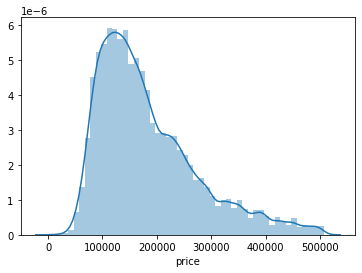

In [45]:
sns.distplot(ds.price)

Claramente las instancias con precios altos son menores y por ende al momento de entrenar contamos con menos información para entrenarlo. Esta sin duda es una de las causas por las cuales el modelo no performa tan bien cuando intentamos predecir propiedades con gran cantidad de superficie cubierta o superficie total

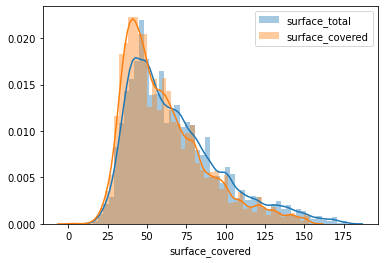

In [46]:
ax=sns.distplot(ds.surface_total, label="surface_total")
ax=sns.distplot(ds.surface_covered, label='surface_covered')
plt.legend()


Los mismo sucede con las superficie total y la superficie cubierta las instancias de entrenamiento claramente son menores.Lo que hace que el set de entrenamiento sea menor y por ende la predicción no sea tan buena


**¿Que mejoraria?**

Claramente la selección del dataset no aplica para propiedades de alto costo. Deberíamos intentar conseguir más información de las propiedades más costosas para tener más instancias y así poder lograr una mejor predicción. Con este dataset yo trabajaría con propiedades de no más de $150.000.

Respecto de los modelos evaluados. Está claro que no es un modelo para una regresión lineal, pero una polémica se comportó relativamente bien. Claramente randomForest con sus hiperparametros depurados presenta una mejoría pero no tan substancial respecto de una arbol de decision convencional solo hay un 2% de mejoría en la predicción. Si pongo en la balanza el costo de entrenamiento versus los beneficios. No estaría mal utilizar un método de árboles de decisión convencional.